In [1]:
# pip install git+https://github.com/sign-language-processing/datasets.git -q

## Dataset download

In [1]:
import tensorflow_datasets as tfds
# import sign_language_datasets.datasets
from sign_language_datasets.utils.torch_dataset import TFDSTorchDataset
from sign_language_datasets.datasets.config import SignDatasetConfig

import itertools

/opt/homebrew/Caskroom/miniforge/base/envs/slt_models_tryout/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = "."

In [3]:
config = SignDatasetConfig(name="rwth_phoenix2014_t_poses", version="3.0.0", include_video=False, include_pose="holistic")
rwth_phoenix2014_t = tfds.load(name='rwth_phoenix2014_t', builder_kwargs=dict(config=config), data_dir=DATA_DIR)

In [4]:
train_dataset = TFDSTorchDataset(rwth_phoenix2014_t["train"])
test_dataset = TFDSTorchDataset(rwth_phoenix2014_t["test"])

In [5]:
for datum in itertools.islice(train_dataset, 0, 5):
	print((datum.keys()))
	print(f"Pose shape: {datum['pose']['data'].shape}")
	print(f"Text: {datum['text'].decode('utf-8')}")
	print()

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([47, 1, 543, 3])
Text: guten abend liebe zuschauer

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([56, 1, 543, 3])
Text: im bergland fällt zunehmend schnee

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([70, 1, 543, 3])
Text: und der wind weht auch noch kräftig aus west bis nordwest

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([99, 1, 543, 3])
Text: die aussichten von montag bis mittwoch ändert sich das wetter kaum

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([123, 1, 543, 3])
Text: über dem bergland können sich einzelne quellwolken zeigen in küstennähe gibt es auch mal dichtere wolken



## Dataset analysis

In [ ]:
src_lenghts = []
texts = []

for datum in rwth_phoenix2014_t["train"]:
	src_lenghts.append(datum['pose']['data'].shape[0])
	texts.append(datum['text'].numpy().decode('utf-8'))

### Frames analysis for padding and truncation

In [ ]:
import pandas as pd


src_lengths_df = pd.Series(src_lenghts)
src_lengths_df.describe(percentiles=[.75, .9, .95, .99])

count    7096.000000
mean      116.594419
std        49.859426
min        16.000000
50%       112.000000
75%       144.000000
90%       182.000000
95%       208.000000
99%       259.000000
max       475.000000
dtype: float64

<Axes: >

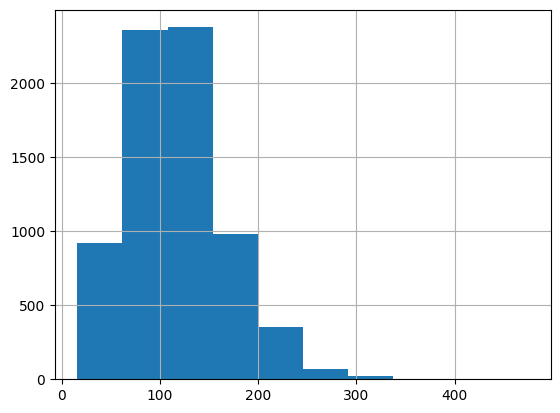

In [ ]:
src_lengths_df.hist()

### Text tokenization and analysis for padding and truncation

In [5]:
from transformers import AutoTokenizer


TEXT_MODEL = "google-bert/bert-base-german-cased"
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)

In [6]:
BOS_IDX = tokenizer.cls_token_id if tokenizer.cls_token_id is not None else -1
EOS_IDX = tokenizer.sep_token_id if tokenizer.sep_token_id is not None else -1
PAD_IDX = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else -1

print(f"BOS_IDX: {BOS_IDX}, EOS_IDX: {EOS_IDX}, PAD_IDX: {PAD_IDX}")

BOS_IDX: 3, EOS_IDX: 4, PAD_IDX: 0


In [ ]:
tokenized_sequences = tokenizer(texts, padding=True)

In [ ]:
tokens_length = [len(tokens) for tokens in tokenized_sequences['input_ids']]
print(max(tokens_length))

69


In [ ]:
print(texts[0])
print(tokenized_sequences[0].ids)

guten abend liebe zuschauer
[3, 5569, 12560, 16619, 2435, 8, 923, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Preprocessing and dataloader generation

In [7]:
import torch
from torch import Tensor
import torch.utils.data as utils


MAX_FRAMES = 259
MAX_TOKENS = 150
BATCH_SIZE = 4

def flatten_keypoints(datum: Tensor):
	'''
		Reshape the pose of datum only keeping the first dimension S (sequence lenght) and flattening the number of keypoints K and their dimensions D.
		Args:
			datum: Tensor of shape (S, D, K)
		Returns:
			Tensor of shape (frames, D * K)
	'''
	return datum.view(datum.size(0), -1)

def pad_truncate_src(datum: Tensor, max_len: int):
	'''Pad the pose to max_len or truncate it'''
	if datum.size(0) < max_len:
		return torch.cat([datum, torch.zeros(max_len - datum.size(0), datum.size(1))])
	else:
		return datum[:max_len]

def collate_fn(batch):
	src = [item['pose']['data'] for item in batch]
	src = torch.stack([pad_truncate_src(flatten_keypoints(datum), MAX_FRAMES) for datum in src])
	tgt = [str(item['text'].decode('utf-8')) for item in batch]
	tgt = tokenizer(tgt, padding='max_length', max_length=MAX_TOKENS, return_tensors='pt').input_ids
	return src, tgt

train_loader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [9]:
for src, tgt in train_loader:
  print(src.shape)
  print(tgt.shape)
  break

torch.Size([4, 259, 1629])
torch.Size([4, 100])


## Model

### Model definition

In [ ]:
# !pip install lightning -q

In [8]:
import torch


def generate_square_subsequent_mask(size: int, device: torch.device):
    '''
        Generates triangular (size, size) mask for the transformer model.
    '''
    mask = (torch.triu(torch.ones((size, size))) == 1).transpose(0, 1).to(device)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_target_mask(tgt: Tensor, pad_idx: int, device: torch.device):
    '''
        Create target mask and padding mask for the transformer model.
        Args:
            tgt: (N, T) where N is the batch size and T is the target sequence length
            pad_idx: padding index
            device: torch device
        Returns:
            tgt_mask: (T, T), so to evaluate the i-th token, we can only look at the first i tokens, for all i's
            tgt_padding_mask: (N, T), for masking pad tokens
    '''
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    tgt_padding_mask = (tgt == pad_idx)
    return tgt_mask, tgt_padding_mask

In [9]:
from torch import Tensor, nn
from torch.nn.functional import relu


class KeypointsEmbedding(nn.Module):

    def __init__(self,
                in_features: int,
                keys_emb_size: int = 128,
                kernel_size: int = 5,
                out_channels: int = 64,
                ):
        super(KeypointsEmbedding, self).__init__()

        self.fc = nn.Linear(in_features=in_features, out_features=keys_emb_size)
        self.conv1d = nn.Conv1d(in_channels=keys_emb_size, out_channels=out_channels, kernel_size=kernel_size)

    def forward(self, src_batch: Tensor):
        '''
            Applies a fully connected layer to each frame of the sequence and then a 1d convolution over the sequence.
            Args:
                src_batch: (N, S, E)
            Returns:
                Embedding tensor of shape (N, S - kernel_size + 1, out_channels)
        '''
        # Flatten S and N dims and apply fc frame by frame
        n, s, e = src_batch.shape
        src_batch = src_batch.view(n*s ,-1)
        src_emb = relu(self.fc(src_batch)).view(n, s, -1)
        # Apply 1d convolution over S dim
        src_emb = src_emb.permute(0, 2, 1)
        src_emb = self.conv1d(src_emb).permute(0, 2, 1)
        return src_emb

In [10]:
import math
import torch
from torch import nn, Tensor


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        '''
        Apply positional encoding to the input tensor.
        Args:
            x: (N, S, E)
        Returns:
            Tensor of shape (N, S, E)
        '''
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [11]:
import math
from torch import nn, Tensor


class TokenEmbedding(nn.Module):
    '''Code taken from https://pytorch.org/tutorials/beginner/translation_transformer.html'''

    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        '''
            Applies token embedding to the target tensor.
            Args:
                tokens: (N, T)
            Returns:
                Tensor of shape (N, T, E)
        '''
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
# from transformers import AutoModel

# bert_german = AutoModel.from_pretrained(TEXT_MODEL)

In [12]:
from torch import Tensor, nn


class KeypointsTransformer(nn.Module):
    '''
        Transformer model for sign language translation. It uses a 1D convolutional layer to embed the keypoints and a transformer to translate the sequence.
        S refers to the source sequence length, T to the target sequence length, N to the batch size, and E is the features number.
    '''

    def __init__(self,
                src_max_len: int,
                tgt_max_len: int,
                in_features: int,
                tgt_vocab_size: int,
                d_model: int = 64,
                kernel_size: int = 5,
                keys_emb_size: int = 128,
                dropout: float = 0.1
                ):
        '''
            Args:
                src_max_len: max length of the source sequence
                tgt_max_len: max length of the target sequence
                in_features: number of features of the input (amount of keypoints * amount of coordinates)
                tgt_vocab_size: size of the target vocabulary
                d_model: number of dimensions of the encoding vectors (default=64). Must be even so the positional encoding works.
                kernel_size: the size of the 1D convolution window (default=5)
                keys_initial_emb_size: the size of the keys embedding (default=128)
        '''
        super(KeypointsTransformer, self).__init__()

        self.keys_emb = KeypointsEmbedding(in_features=in_features, keys_emb_size=keys_emb_size, kernel_size=kernel_size, out_channels=d_model)
        self.src_pe = PositionalEncoding(d_model=d_model, max_len=src_max_len - kernel_size + 1)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, d_model)
        self.tgt_pe = PositionalEncoding(d_model=d_model, max_len=tgt_max_len)
        self.transformer = nn.Transformer(d_model=d_model, dropout=dropout, batch_first=True)
        self.generator = nn.Linear(d_model, tgt_vocab_size)


    def forward(self,
                src: Tensor,
                tgt: Tensor,
                tgt_mask: Tensor,
                tgt_padding_mask: Tensor
    ):
        '''
            Forward pass of the model.
            Args:
                src: (N, S, E)
                tgt: (N, T, E)
                tgt_mask: (T, T)
                tgt_padding_mask: (N, T)
            Returns:
                Tensor of shape (N, T, tgt_vocab_size)
        '''
        src_emb = self.keys_emb(src)
        src_emb = self.src_pe(src_emb)
        tgt_emb = self.tgt_pe(self.tgt_tok_emb(tgt))
        # src_mask and src_key_padding_mask are set to none as we use the whole input at every timestep
        outs = self.transformer(
            src = src_emb,
            tgt = tgt_emb,
            src_mask = None,
            tgt_mask = tgt_mask,
            src_key_padding_mask = None,
            tgt_key_padding_mask = tgt_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor):
        src_emb = self.src_pe(self.keys_emb(src))
        return self.transformer.encoder(src_emb, None)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.tgt_pe(self.tgt_tok_emb(tgt)), memory, tgt_mask)

KEYS_EMB_SIZE = 64
D_MODEL = 64
KERNEL_SIZE = 15
DROPOUT = 0.2

model = KeypointsTransformer(\
    src_max_len=MAX_FRAMES, 
    tgt_max_len=MAX_TOKENS, 
    in_features=543*3, 
    tgt_vocab_size=tokenizer.vocab_size,
    d_model=D_MODEL,
    kernel_size=KERNEL_SIZE,
    keys_emb_size=KEYS_EMB_SIZE,
    dropout=DROPOUT
)

In [ ]:
# !pip install modelsummary -q

In [ ]:
from modelsummary import summary


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for src, tgt in train_loader:
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)
    tgt_mask, tgt_padding_mask = create_target_mask(tgt, PAD_IDX, DEVICE)
    print(src.shape, tgt.shape, tgt_mask.shape, tgt_padding_mask.shape)
    model = model.to(DEVICE)
    summary(model, src, tgt, tgt_mask, tgt_padding_mask)
    break

## Model training

In [ ]:
# !pip install wandb -q

In [13]:
from torch import Tensor
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy
import lightning as L


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class LKeypointsTransformer(L.LightningModule):

    def __init__(self, model: KeypointsTransformer, num_classes: int):
        super().__init__()
        self.model = model
        self.loss_fn = cross_entropy
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes, ignore_index=PAD_IDX)
        self.save_hyperparameters()

    def forward(self, src: Tensor, tgt: Tensor, tgt_mask: Tensor, tgt_padding_mask: Tensor):
        return self.model(src, tgt, tgt_mask, tgt_padding_mask)
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def run_on_batch(self, batch):
        src, tgt = batch
        # tgt_input and tgt_ouptut are displaced by one position, so tgt_input[i] is the input to the model and tgt_output[i] is the expected output
        tgt_input = tgt[:, :-1]
        tgt_mask, tgt_padding_mask = create_target_mask(tgt_input, PAD_IDX, DEVICE)
        logits = self.model(src, tgt_input, tgt_mask, tgt_padding_mask)
        tgt_output = tgt[:, 1:]
        loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1), ignore_index=PAD_IDX)
        accuracy = self.accuracy(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.run_on_batch(batch)
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.run_on_batch(batch)
        self.log("val_loss", loss)
        self.log("val_accuracy", accuracy)

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.run_on_batch(batch)
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)
        return loss, accuracy
    
    # function to generate output sequence using greedy algorithm
    def greedy_translate(self, src):
        memory = self.model.encode(src)
        ys = torch.ones(1, 1).fill_(BOS_IDX).to(DEVICE)
        for i in range(MAX_TOKENS-1):
            tgt_mask = generate_square_subsequent_mask(ys.size(1), DEVICE)
            out = model.decode(ys, memory, tgt_mask)
            prob = model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()
            print(next_word)
            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
            if next_word == EOS_IDX:
                break
        return tokenizer.decode([int(x) for x in ys[0].tolist()], skip_special_tokens=True)

# CHKP = "rwth/e3lz0h2y/checkpoints/epoch=4-step=2220.ckpt"

l_model = LKeypointsTransformer(model, tokenizer.vocab_size)
# l_model = LKeypointsTransformer.load_from_checkpoint(CHKP, model=model, num_classes=tokenizer.vocab_size)

/opt/homebrew/Caskroom/miniforge/base/envs/slt_models_tryout/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [16]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger


wandb_logger = WandbLogger(project="rwth")
wandb_logger.experiment.config.update({
	"BATCH_SIZE": BATCH_SIZE, 
	"DEVICE": DEVICE,
	"MAX_FRAMES": MAX_FRAMES,
	"MAX_TOKENS": MAX_TOKENS,
	"TEXT_MODEL": TEXT_MODEL,
	"KEYS_EMB_SIZE": KEYS_EMB_SIZE,
	"D_MODEL": D_MODEL,
	"KERNEL_SIZE": KERNEL_SIZE,
	"DROPOUT": DROPOUT,
})

trainer = L.Trainer(
    logger=wandb_logger,
    default_root_dir="./checkpoint",
    callbacks=[
		EarlyStopping(monitor="val_loss", mode="min", patience=5),
		ModelCheckpoint(
			monitor='val_loss',
			dirpath='checkpoints/',
			filename='rwth-{epoch:02d}-{step:02d}-{val_loss:.2f}',
			mode='min',
			save_last=True
		),],
)

INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(
    model=l_model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
    ckpt_path="checkpoints/rwth-epoch=00-step=1774-val_loss=5.75.ckpt"
)

INFO: Restoring states from the checkpoint path at checkpoints/rwth-epoch=00-step=1774-val_loss=5.75.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/rwth-epoch=00-step=1774-val_loss=5.75.ckpt
INFO: 
  | Name     | Type                 | Params
--------------------------------------------------
0 | model    | KeypointsTransformer | 7.5 M 
1 | accuracy | MulticlassAccuracy   | 0     
--------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
30.042    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type                 | Params
--------------------------------------------------
0 | model    | KeypointsTransformer | 7.5 M 
1 | accuracy | MulticlassAccuracy   | 0     
--------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
30.042    T

Epoch 1:  11%|█▏        | 202/1774 [01:21<10:37,  2.46it/s, v_num=26j2]    

In [29]:
# load model from checkpoints folder as the latter updated file
# l_model = LKeypointsTransformer.load_from_checkpoint(, model=model, num_classes=tokenizer.vocab_size)

trainer.test(
    model=l_model,
	dataloaders=test_loader,
    ckpt_path="checkpoints/rwth-epoch=00-step=1774-val_loss=1.12.ckpt"
)

INFO: Restoring states from the checkpoint path at checkpoints/rwth-epoch=00-step=1774-val_loss=1.12.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/rwth-epoch=00-step=1774-val_loss=1.12.ckpt
INFO: Loaded model weights from the checkpoint at checkpoints/rwth-epoch=00-step=1774-val_loss=1.12.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at checkpoints/rwth-epoch=00-step=1774-val_loss=1.12.ckpt
/opt/homebrew/Caskroom/miniforge/base/envs/slt_models_tryout/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/slt_models_tryout/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` 

Testing DataLoader 0:   1%|          | 2/161 [00:00<00:21,  7.36it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/slt_models_tryout/lib/python3.11/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Testing DataLoader 0: 100%|██████████| 161/161 [00:09<00:00, 16.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8729851841926575
        test_loss           1.1200644969940186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1200644969940186, 'test_accuracy': 0.8729851841926575}]

In [30]:
import pandas as pd
from torchmetrics.functional.text import bleu_score


try:
	results_df = pd.read_csv("results.csv")
	last_idx = len(results_df)
except:
	results_df = pd.DataFrame(columns=["pred", "tgt", "bleu_1", "bleu_2", "bleu_3", "bleu_4"])
	last_idx = 0

results = []
for batch_idx, (src, tgt) in enumerate(test_loader):
	src = src.to(DEVICE)
	for i in range(len(src)):
		if last_idx > batch_idx * 4 + i:
			continue
		print(f"Batch {batch_idx}, sample {i}")
		# adds extra dimension representing the batch
		src_0 = src[i].unsqueeze(0)
		l_model = l_model.to(DEVICE)
		pred = (l_model.greedy_translate(src_0))
		y = tokenizer.decode([int(x) for x in tgt[i].tolist()], skip_special_tokens=True, clean_up_tokenization_spaces=True)
		results.append((pred, y) + tuple(bleu_score(pred, [y], n_gram=n).item() for n in range(1, 5)))

Batch 25, sample 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [23]:
results_df = pd.concat([results_df, pd.DataFrame(results, columns=["pred", "tgt", "bleu_1", "bleu_2", "bleu_3", "bleu_4"])])
results_df.to_csv("results.csv", index=False)
results_df.head()

/var/folders/x8/hdnyb6hn6zjgxbcjfqcz3mqw0000gn/T/ipykernel_89421/1906029009.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(results, columns=["pred", "tgt", "bleu_1", "bleu_2", "bleu_3", "bleu_4"])])


,pred,tgt,bleu_1,bleu_2,bleu_3,bleu_4
0,,denn im süden haben wir die schwül warme gewit...,0.0,0.0,0.0,0.0
1,,ab sonntag wird es wieder milder dabei gibt es...,0.0,0.0,0.0,0.0
2,,donnerstag und freitag ändert sich wenig an di...,0.0,0.0,0.0,0.0
3,,am tag ist es im südosten meist stark bewölkt ...,0.0,0.0,0.0,0.0
4,,das hoch über skandinavien verlagert sich ein ...,0.0,0.0,0.0,0.0


In [24]:
results_df.describe()

,bleu_1,bleu_2,bleu_3,bleu_4
count,100.0,100.0,100.0,100.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0
